- https://github.com/python-hydro/hydro_examples/blob/master/elliptic/poisson_fft.py
- Page 16 of https://astro.uchicago.edu/~andrey/Talks/PM/pm.pdf
- https://fast-poisson-solver.readthedocs.io/en/latest/

https://physics.stackexchange.com/questions/773566/poisson-equation-in-cosmology-at-first-order-in-perturbation-theory

https://github.com/grkooij/Cosmological-Particle-Mesh-Simulation

In [1]:
import numpy as np

In [2]:
import pyfftw

In [3]:
import time
arr = np.load('Run2_3061_1.npy')
gr = arr[:,:256]
delta = gr/gr.mean() - 1
BoxSize = 128.0

# This function performs the 2D FFT of a field in single precision
def FFT2Dr_f(a, threads):

    # align arrays
    grid  = len(a)
    a_in  = pyfftw.empty_aligned((grid,grid),    dtype='float32')
    a_out = pyfftw.empty_aligned((grid,grid//2+1),dtype='complex64')

    # plan FFTW
    fftw_plan = pyfftw.FFTW(a_in, a_out, axes=(0,1),
                            flags=('FFTW_ESTIMATE',),
                            direction='FFTW_FORWARD', threads=threads)
                            
    # put input array into delta_r and perform FFTW
    a_in [:] = a;  fftw_plan(a_in,a_out);  return a_out

# same as frequencies but in 2D
def frequencies_2D(BoxSize,dims):
    kF = 2.0*np.pi/BoxSize;  middle = dims//2;  kN = middle*kF
    kmax_par = middle
    kmax_per = middle
    kmax     = int(np.sqrt(middle**2 + middle**2))
    return kF,kN,kmax_par,kmax_per,kmax

# This function checks that all independent modes have been counted
def check_number_modes_2D(Nmodes,dims):
    # (0,0) own antivector, while (n,n) has (-n,-n) for dims odd
    if dims%2==1:  own_modes = 1 
    # (0,0),(0,n),(0,n),(n,0),(n,n)
    else:          own_modes = 4
    repeated_modes = (dims**2 - own_modes)//2  
    indep_modes    = repeated_modes + own_modes

    if int(np.sum(Nmodes))!=indep_modes:
        print('WARNING: Not all modes counted')
        print('Counted  %d independent modes'%(int(np.sum(Nmodes))))
        print('Expected %d independent modes'%indep_modes)
        sys.exit() 

# find dimensions of delta: we assume is a (grid,grid) array
# determine the different frequencies and the MAS_index
grid = len(delta);  middle = grid//2
kF,kN,kmax_par,kmax_per,kmax = frequencies_2D(BoxSize,grid)

## compute FFT of the field (change this for double precision) ##
threads = 1
delta_k = FFT2Dr_f(delta,threads)
#################################

# define arrays containing k3D, Pk3D and Nmodes3D. We need kmax+1
# bins since the mode (middle,middle, middle) has an index = kmax
k2D    = np.zeros(kmax+1, dtype=np.float64)
Pk2D   = np.zeros(kmax+1, dtype=np.float64)
Nmodes = np.zeros(kmax+1, dtype=np.float64)

# do a loop over the independent modes.
# compute k,k_par,k_per, mu for each mode. k's are in kF units
start2 = time.time();  prefact = np.pi/grid
for kxx in range(grid):
    kx = (kxx-grid if (kxx>middle) else kxx)

    for kyy in range(middle+1): #kyy=[0,1,..,middle] --> ky>0
        ky = (kyy-grid if (kyy>middle) else kyy)

        # ky=0 & ky=middle are special (modes with (kx<0, ky=0) are not
        # independent of (kx>0, ky=0): delta(-k)=delta*(+k))
        if ky==0 or (ky==middle and grid%2==0):
            if kx<0:  continue

        # compute |k| of the mode and its integer part
        k       = np.sqrt(kx*kx + ky*ky)
        k_index = int(k)

        # Pk
        k2D[k_index]    += k
        Nmodes[k_index] += 1.0

# Pk2D. Check modes, discard DC mode bin and give units
check_number_modes_2D(Nmodes,grid)
k2D  = k2D[1:];  Nmodes = Nmodes[1:];  Pk2D = Pk2D[1:]
for i in range(len(k2D)):
    k2D[i]  = (k2D[i]/Nmodes[i])*kF
    Pk2D[i] = (Pk2D[i]/Nmodes[i])*(BoxSize/grid**2)**2
k  = np.asarray(k2D);  Nmodes = np.asarray(Nmodes)

In [53]:
# ******** SEE https://github.com/grkooij/Cosmological-Particle-Mesh-Simulation/blob/master/src/configure_me.py ********
N_PARTS          = 256 # Number of particles in one dimension
BOX_SIZE         = 128 # Box size in Mpc/h in one dimension
N_CELLS          = 256 # Number of cells in one dimension
N_CPU            = 1 # Number of cpu's used

def potential_k(density_k):
    scale = 2*np.pi*N_PARTS/BOX_SIZE
    lxaxis = scale*np.fft.fftfreq(N_PARTS)
    lyaxis = scale*np.fft.fftfreq(N_PARTS)
    # lzaxis = scale*np.fft.fftfreq(N_PARTS)

    #3D Fourier axes
    ly, lx = np.meshgrid(lyaxis, lxaxis, indexing='ij')   

    #-k squared operator where k = sqrt(lx**2 + ly**2 + lz**2)
    del_sq = -(lx**2 + ly**2)

    #Calculating potential and correcting for scale with mass resolution
    return np.divide(density_k, del_sq, where=del_sq!=0)

def potential_real(potential_k):
    #Performing the inverse Fourier transform to obtain potential in real space
    fft_grid = np.zeros([N_CELLS, N_CELLS], dtype=np.cdouble)
    ifft_object = pyfftw.FFTW(potential_k, fft_grid, direction = 'FFTW_BACKWARD',axes=(0,1), threads = N_CPU)

    return (ifft_object().real).astype('float32')

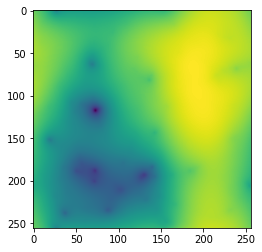

In [54]:
density_k = np.fft.fftn(arr[:, :256])
pot_real = potential_real(potential_k(density_k))
plt.imshow(pot_real)

# TODO: For f(R), a diff Poisson eqn exists, so solution will be different...see chatgpt for solution. See eqn 1.37 of https://arxiv.org/pdf/2303.07121.pdf

In [7]:
# kx = 2 * np.pi * np.fft.fftfreq(N, d=dx) / L
# ky = 2 * np.pi * np.fft.fftfreq(N, d=dx) / L

# l = np.arange(0, N, 1)
# m = np.arange(0, N, 1)

# kx = l * 2 * np.pi / L
# ky = m * 2 * np.pi / L
# kx, ky

In [8]:
arr = np.load('Run2_3061_1.npy')

import numpy as np
# from scipy.fftpack import fftn, ifftn, ifftshift

G = 6.6743 * 10**(-11)
a = 1  # scale factor for z = 0.

# Define parameters
L = 128.0  # Size of the box
N = 256    # Number of grid points
dx = L / N  # Grid spacing

kx = 2 * np.pi * np.fft.fftfreq(N, d=dx) / L
ky = 2 * np.pi * np.fft.fftfreq(N, d=dx) / L

# make 2-d arrays for the wavenumbers
# See https://github.com/python-hydro/hydro_examples/blob/master/elliptic/poisson_fft.py
kx2d = np.repeat(kx, N)
kx2d.shape = (N, N)

ky2d = np.repeat(ky, N)
ky2d.shape = (N, N)
ky2d = np.transpose(ky2d)

def calculate_potential(rho):
    rho_m = rho.mean()

    delta = rho / rho_m - 1
    # delta_m = FFT2Dr_f(delta, 1)
    delta_m = np.fft.fftn(delta)
    # print(delta_m.shape)

    # Avoid division by zero by adding a small constant
    denom = kx2d**2 + ky2d**2
    # denom[denom == 0.0] = 1e-10

    #phi_k = (4 * np.pi * G * rho_m * a**2 * delta_m) / (KX**2 + KY**2 + KZ**2)
    phi_k = -1 * (4 * np.pi * G * rho_m * a**2 * delta_m) / denom

    # SE PG 16 OF https://astro.uchicago.edu/~andrey/Talks/PM/pm.pdf and also slide 15 of https://astro.uchicago.edu/~andrey/Talks/PM/pm.pdf
    phi_k[denom == 0.0] = 0

    # Inverse Fourier transform to get potential in real space
    phi = np.real(np.fft.ifftn(phi_k))

    return phi

grp=calculate_potential(arr[:, :256])
frp=calculate_potential(arr[:, 256:])

grp[grp>np.quantile(grp, 0.99)]=np.quantile(grp,0.99)
grp[grp<np.quantile(grp, 0.01)]=np.quantile(grp,0.01)
frp[frp>np.quantile(frp, 0.99)]=np.quantile(frp,0.99)
frp[frp<np.quantile(frp, 0.01)]=np.quantile(frp,0.01)

/tmp/ipykernel_16797/3128982298.py:39: RuntimeWarning: divide by zero encountered in true_divide
  phi_k = -1 * (4 * np.pi * G * rho_m * a**2 * delta_m) / denom
/tmp/ipykernel_16797/3128982298.py:39: RuntimeWarning: invalid value encountered in true_divide
  phi_k = -1 * (4 * np.pi * G * rho_m * a**2 * delta_m) / denom


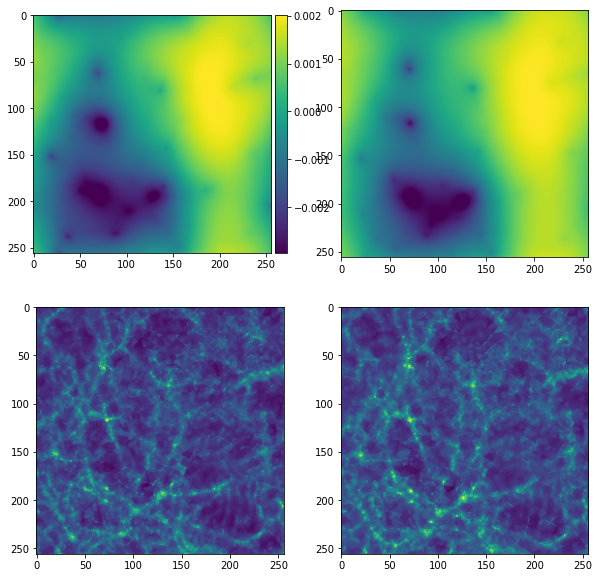

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,1].imshow(frp)
ax[1,0].imshow(np.log10(arr[:,:256]))
ax[1,1].imshow(np.log10(arr[:,256:]))

divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)

im=ax[0,0].imshow(grp)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [10]:
grp

array([[0.00052032, 0.00047925, 0.00043644, ..., 0.00063411, 0.00059783,
        0.00055976],
       [0.00054252, 0.00050178, 0.00045936, ..., 0.00065236, 0.00061855,
        0.00058138],
       [0.00056466, 0.00052425, 0.00048212, ..., 0.00067517, 0.00064013,
        0.00060323],
       ...,
       [0.00045715, 0.00041401, 0.00036997, ..., 0.00058763, 0.00054363,
        0.00049952],
       [0.0004768 , 0.00043487, 0.00039115, ..., 0.00060254, 0.00055951,
        0.00051692],
       [0.00049811, 0.00045671, 0.00041345, ..., 0.0006178 , 0.00057754,
        0.00053785]])

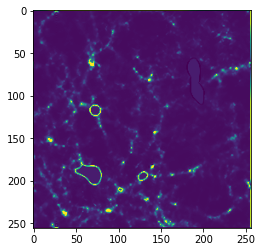

In [31]:
def laplacian_of_potential(phi, dx, dy):
    # Calculate the Laplacian of the potential phi
    d2phi_dx2 = np.gradient(np.gradient(phi, axis=0), axis=0) / dx**2
    d2phi_dy2 = np.gradient(np.gradient(phi, axis=1), axis=1) / dy**2

    # Sum the second derivatives to obtain the Laplacian
    laplacian_result = d2phi_dx2 + d2phi_dy2

    return laplacian_result

from scipy.signal import convolve2d

def apply_2d_laplacian(grid, dx, dy):
    """
    Apply a 2D Laplacian operator to a 2D grid using finite differences.

    Parameters:
    - grid: 2D numpy array representing the input grid.
    - dx: Grid spacing in the x-direction.
    - dy: Grid spacing in the y-direction.

    Returns:
    - laplacian_result: 2D numpy array containing the result of the Laplacian operator.
    """

    # Calculate the finite difference coefficients
    alpha = 1 / dx**2
    beta = 1 / dy**2

    # Define a 3x3 Laplacian kernel with finite differences
    laplacian_kernel = np.array([[0, beta, 0], [beta, -2 * (alpha + beta), beta], [0, beta, 0]])

    # Apply the Laplacian operator using convolution
    laplacian_result = convolve2d(grid, laplacian_kernel, mode='same', boundary='symm')

    return laplacian_result

# Example usage for a 2D array potential
# Assuming you have a 2D potential array 'phi' with spacing dx and dy
# Call the function to calculate the Laplacian
laplacian_result = apply_2d_laplacian(grp, dx, dx)

laplacian_result[laplacian_result>np.quantile(laplacian_result, 0.99)]=np.quantile(laplacian_result,0.99)
laplacian_result[laplacian_result<np.quantile(laplacian_result, 0.01)]=np.quantile(laplacian_result,0.01)

plt.imshow(laplacian_result)

In [32]:
def get_delta_R(laplacian_result, rho):
    x = laplacian_result - (16 / 3) * np.pi * G * a**2 * (rho - rho.mean())
    return (6 * x) / (a**2)

delta_R = get_delta_R(laplacian_result, arr[:, :256])

In [33]:
delta_R.shape

(256, 256)

In [34]:
def scalar_field_draft(delta_R, rho):
    return (-1/3) * a**2 * (delta_R + 8 * np.pi * G * (rho - rho.mean()))

scalar_field_draft_field = scalar_field_draft(delta_R, arr[:, :256])

from scipy.sparse import diags
# from scipy.sparse.linalg import cg
from scipy.linalg import solve

def invert_2d_laplacian(laplacian_result, dx, dy):
    """
    Invert the operation of a 2D Laplacian operator applied to a grid.

    Parameters:
    - laplacian_result: 2D numpy array containing the Laplacian result.
    - dx: Grid spacing in the x-direction.
    - dy: Grid spacing in the y-direction.

    Returns:
    - inverted_result: 2D numpy array containing the inverted result.
    """

    # Calculate the finite difference coefficients
    alpha = 1 / dx**2
    beta = 1 / dy**2

    # Construct the Laplacian matrix
    N = laplacian_result.shape[0]
    laplacian_matrix = -2 * (alpha + beta) * np.eye(N) + beta * (np.eye(N, k=1) + np.eye(N, k=-1))

    # Ensure laplacian_result is flattened
    flat_laplacian_result = laplacian_result

    # Invert the Laplacian matrix using scipy.linalg.solve
    inverted_result = solve(laplacian_matrix, flat_laplacian_result)

    return inverted_result.reshape((N, N))


# Call the function to invert the Laplacian
scalar_field = invert_2d_laplacian(scalar_field_draft_field, dx, dx)

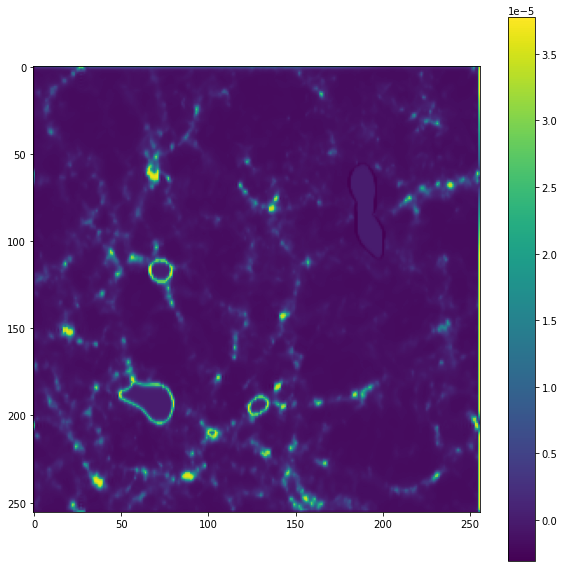

In [35]:
plt.figure(figsize=(10, 10)); plt.imshow(scalar_field); plt.colorbar(); plt.show()

In [36]:
scalar_field.shape

(256, 256)

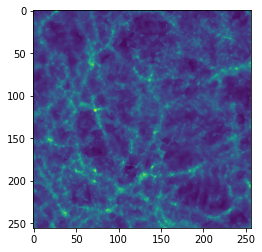

In [37]:
plt.imshow(np.log10(arr[:, :256]))